# Mean Variance Frontiers

This notebook calculates *(a)* the mean-variance frontiers when there are no portfolio restrictions; *(b)* the tangency portfolio.

## Load Packages and Extra Functions

In [1]:
using Printf, LinearAlgebra

include("src/printmat.jl");

prec = 2;    #default number of decimal digits in printmat()

In [2]:
using Plots
default(size = (480,320),fmt = :png)   #or :svg

# The MV Frontier

Mean variance (MV) analysis starts with providing the vector of expected returns $\mu$ and the covariance matrix $\Sigma$ of the investable assets.

Then, it plots the "mean variance" frontier: it is a scatter plot showing the lowest possible portfolio standard deviation ($\text{Std}(R_p)$) on the horizontal axis (yes, the standard deviation, not the variance) at a required average return ($\text{E}R_p=\mu^*$) on the vertical axis. We consider many different $\mu^*$ values to create the scatter. In most figures we connect the dots to form a curve.

Remember: to calculate the expected return and the variance of a portfolio with portfolio weights in the vector $w$, use 

$\text{E}R_p = w'\mu$ and 

$\text{Var}(R_p) = w'\Sigma w$.

Also, the sum of the portfolio weights should equal 1.

# MV Frontier  with Two Assets

With only two investable assets, all portfolios of them are on the MV frontier. We can therefore trace out the entire MV frontier by calculating the means and standard deviations of a range of portfolios with different weights ($w_1,1-w_1$) on the two assets.

In [3]:
μ = [11.5, 6]/100            #expected returns
Σ = [166   58;               #covariance matrix
      58  100]/100^2

printblue("expected returns, %:")
printmat(μ*100;rowNames=["asset 1","asset 2"],prec)         #prec is defined above

printblue("covariance matrix, bp:")
printmat(Σ*100^2;rowNames=["asset 1","asset 2"],colNames=["asset 1","asset 2"],prec)

expected returns, %:
asset 1     11.50
asset 2      6.00

covariance matrix, bp:
          asset 1   asset 2
asset 1    166.00     58.00
asset 2     58.00    100.00



### Remarks on the Code

For the the code in the next cell, notice the following:

1. `(ERₚ,StdRₚ) = (fill(NaN,L),fill(NaN,L))` creates two $L$-vectors filled with NaNs. (This is the same as having two lines of code.)

2. `local w` makes sure that `w` inside the loop does not affect any previously assigned `w`. In contrast, a `global w` would make the value created in the loop overwrite any previous `w`. In a notebook, `global` is implicitly assumed. In a script (.jl) file, you typically have to explicitly indicate local/global.

In [4]:
L        = 41                            #number of w₁ values to try
w₁_range = range(1.5,-0.5,length=L)      #different possible weights on asset 1

(ERₚ,StdRₚ) = (fill(NaN,L),fill(NaN,L))   #to put the results in
for i in 1:L
    #local w                                #local/global is needed in script
    w        = [w₁_range[i],1-w₁_range[i]]  #weights on asset 1 and 2
    ERₚ[i]   = w'μ
    StdRₚ[i] = sqrt(w'Σ*w)
end

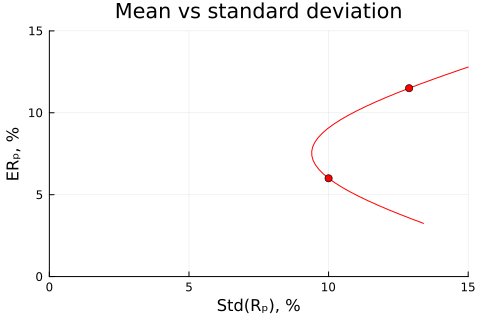

In [5]:
p1 = plot( StdRₚ*100,ERₚ*100,
           legend = nothing,
           linecolor = :red,
           xlim = (0,15),
           ylim = (0,15),
           title = "Mean vs standard deviation",
           xlabel = "Std(Rₚ), %",
           ylabel = "ERₚ, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,markercolor=:red)
display(p1)

# Portfolios of 3 or More (Risky) Assets

The next few cells define the average returns and the covariance matrix for 3 assets and illustrate a few portfolios.

In [6]:
μ = [11.5, 9.5, 6]/100          #expected returns
Σ = [166  34  58;               #covariance matrix
      34  64   4;
      58   4 100]/100^2
Rf = 0.03                       #riskfree return

assetNames = ["A","B","C"]
printblue("μ and Rf in %:")
printmat(μ*100;rowNames=assetNames,prec)
printmat(Rf*100;prec)

printblue("Σ in bp:")
printmat(Σ*100^2;rowNames=assetNames,colNames=assetNames,prec)

μ and Rf in %:
A     11.50
B      9.50
C      6.00

      3.00

Σ in bp:
          A         B         C
A    166.00     34.00     58.00
B     34.00     64.00      4.00
C     58.00      4.00    100.00



In [7]:
wM = [0 0.22 0.02 0.25;            #different portfolios (one in each column)
      1 0.30 0.63 0.68;
      0 0.48 0.35 0.07]
K = size(wM,2)                     #number of different portfolios

(ERₚ,StdRₚ) = (fill(NaN,K),fill(NaN,K))
for i in 1:K                      #loop over columns in wM
    ERₚ[i]   = wM[:,i]'μ
    StdRₚ[i] = sqrt(wM[:,i]'Σ*wM[:,i])
end

printblue("mean and std (in %) of portfolio: ")
printmat([ERₚ';StdRₚ']*100;colNames=["A","1","2","3"],rowNames=["mean","std"],prec)

mean and std (in %) of portfolio: 
             A         1         2         3
mean      9.50      8.26      8.31      9.75
std       8.00      7.40      6.41      7.38



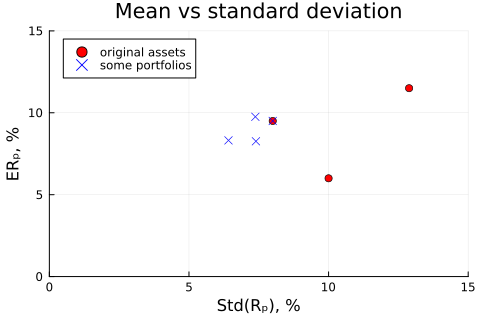

In [8]:
p1 = scatter( sqrt.(diag(Σ))*100,μ*100,
              markercolor = :red,
              label = "original assets",
              xlim = (0,15),
              ylim = (0,15),
              title = "Mean vs standard deviation",
              xlabel = "Std(Rₚ), %",
              ylabel = "ERₚ, %",
              legend = :topleft )
scatter!(StdRₚ*100,ERₚ*100,marker=:x,markercolor=:blue,label="some portfolios")
display(p1)

# Calculating the MV Frontier: 3 or More (Risky) Assets

To find the MV frontier with 3 or more assets we have to solve the optimization problem:

$\min \mathrm{Var}(R_p) \: \text{ s.t. } \: \mathrm{E}R_p = \mu^* \: \mathrm{and} \: \sum_{i=1}^{n}w_{i}=1$.

This can be done with a numerical minimization routine or by linear algebra (at least when we do not put any further restrictions on the portfolio weights). The next cells use the linear algebra approach: it solves for $w$ from the following linear equations (first order conditions):

$$
\begin{bmatrix}
\Sigma & \mu & \mathbf{1}_n\\
\mu^{\prime} & 0 & 0\\
\mathbf{1}_n^{\prime} & 0 & 0
\end{bmatrix}
\begin{bmatrix}
w\\
\lambda\\
\delta
\end{bmatrix}
=%
\begin{bmatrix}
\mathbf{0}_n\\
\mu^{\ast}\\
1
\end{bmatrix}
$$

In [9]:
"""
    MVCalc(μˣ,μ,Σ)

Calculate the std and weights of a portfolio (with mean return μ⁺) on MVF of risky assets.
We use μˣ to denote the required average return, si

# Remark
- The code could be made quicker by calculating `Af = factorize(A)` once and then loop
over different elements in a vector of `μˣ` values as in `wλδ = ...` but using `Af`  instead of `A`.

"""
function MVCalc(μˣ,μ,Σ) #the std of a portfolio on MVF of risky assets
    n    = length(μ)
    A     = [Σ        μ ones(n);   #A is just a name of this matrix, it's not asset A
             μ'       0 0;
             ones(n)' 0 0];
    wλδ   = A\[zeros(n);μˣ;1]
    w     = wλδ[1:n]
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

MVCalc

In [10]:
(StdAt10,wAt10) = MVCalc(0.1,μ,Σ)
printblue("Testing: the portfolio with a mean return of 10%")
printlnPs("\nstd: ",StdAt10)

printblue("\nw and its sum: ")
printmat([wAt10;sum(wAt10)];rowNames=[assetNames;"sum"],prec)

Testing: the portfolio with a mean return of 10%
     
std:      0.077

w and its sum: 
A        0.29
B        0.69
C        0.02
sum      1.00



### A Remark on the Code

- `MVCalc(μˣ,μ,Σ)[1]` picks out the first output from the `MVCalc` function. 

- `StdRₚ = [MVCalc(μˣ,μ,Σ)[1] for μˣ in μˣ_range]` is a loop over the different `μˣ` values in `μˣ_range`

It is the same as writing an explicit loop as in 
```
L     = length(μˣ_range)
StdRₚ = fill(NaN,L)
for i in 1:L
    StdRₚ[i] = MVCalc(μˣ_range[i],μ,Σ)[1]
end
```

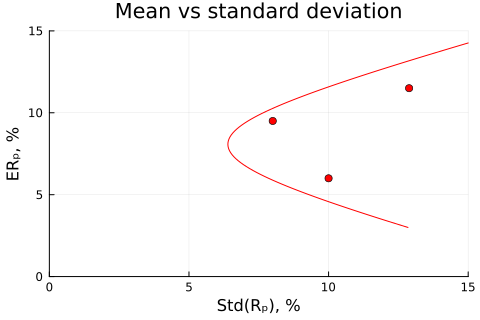

In [11]:
μˣ_range = range(Rf,0.15,length=101)

StdRₚ = [MVCalc(μˣ,μ,Σ)[1] for μˣ in μˣ_range]  #loop over different required average returns, (μˣ_range)

p1 = plot( StdRₚ*100,μˣ_range*100,
           legend = nothing,
           linecolor = :red,
           xlim = (0,15),
           ylim = (0,15),
           title = "Mean vs standard deviation",
           xlabel = "Std(Rₚ), %",
           ylabel = "ERₚ, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,markercolor=:red)
display(p1)

# Calculating the MV Frontier (of Risky and Riskfree Assets)

All portfolios on the MV frontier of both risky and riskfree have (a vector of) portfolio weights on the risky assets as in 

$w=\frac{\mu^{\ast}-R_{f}}{\mu^{e \prime}\Sigma^{-1}\mu^{e}}\Sigma^{-1}
\mu^{e}$, 

where $\mu^*$ is the required average return.

The weight of the riskfree asset is $1-\mathbf{1}'w$.

The cell also contains an alternative formulation based on the first order conditions.

In [12]:
"""
Calculate the std of a portfolio (with mean μˣ) on MVF of (Risky,Riskfree)

# Remark
- This code could be speeded up by calculating `(Σ_1*μᵉ)/(μᵉ'Σ_1*μᵉ) ` once and then
multiply with different values of ``(μˣ-Rf)`.

"""
function MVCalcRf(μˣ,μ,Σ,Rf)
    μᵉ    = μ .- Rf                 #expected excess returns
    Σ_1   = inv(Σ)
    w     = (μˣ-Rf)/(μᵉ'Σ_1*μᵉ) * Σ_1*μᵉ
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end


"""
Alternative calculation of the std of a portfolio (with mean μˣ) on MVF of (Risky,Riskfree)
"""
function MVCalcRfX(μˣ,μ,Σ,Rf)           #calculates the std of a portfolio
    n     = length(μ)                      #on MVF of (Risky,Riskfree)
    μᵉ    = μ .- Rf
    A     = [Σ μᵉ;
            μᵉ' 0]
    wλ    = A\[zeros(n);(μˣ-Rf)]
    w     = wλ[1:n]
    StdRp = sqrt(w'Σ*w)
    return StdRp,w
end

MVCalcRfX

In [13]:
(Std,w) = MVCalcRf(0.1,μ,Σ,Rf)

printblue("Testing: the portfolio with a mean return of 10%")
printlnPs("\nstd: ",Std)

printlnPs("\nw and its sum: ")
printmat([w;sum(w)];rowNames=[assetNames;"sum"],prec)

printlnPs("weight on riskfree:",1-sum(w))

Testing: the portfolio with a mean return of 10%
     
std:      0.076

w and its sum: 
A        0.26
B        0.71
C        0.07
sum      1.04

weight on riskfree:    -0.037


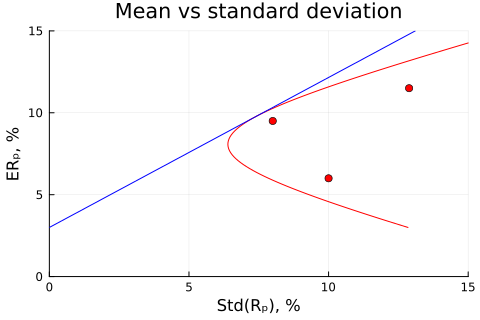

In [14]:
StdRpRf = [MVCalcRf(μˣ,μ,Σ,Rf)[1] for μˣ in μˣ_range]

p1 = plot( [StdRₚ StdRpRf]*100,μˣ_range*100,
           legend = nothing,
           linecolor = [:red :blue],
           xlim = (0,15),
           ylim = (0,15),
           title = "Mean vs standard deviation",
           xlabel = "Std(Rₚ), %",
           ylabel = "ERₚ, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,markercolor=:red)
display(p1)

# Tangency Portfolio

The tangency portfolio is a particular portfolio on the MV frontier of risky and riskfree, where the weights on the risky assets sum to 1. It is therefore also on the MV frontier of risky assets only. The vector of portfolio weights is

$w_{T}=\frac{\Sigma^{-1}\mu^{e}}{\mathbf{1}^{\prime}\Sigma^{-1}\mu^{e}}$

In [15]:
function MVTangencyP(μ,Σ,Rf)           #calculates the tangency portfolio
    n     = length(μ)
    μᵉ    = μ .- Rf                    #expected excess returns
    Σ_1   = inv(Σ)
    w     = Σ_1 *μᵉ/(ones(n)'Σ_1*μᵉ)
    muT   = w'μ + (1-sum(w))*Rf
    StdT  = sqrt(w'Σ*w)
    return w,muT,StdT
end

MVTangencyP (generic function with 1 method)

In [16]:
(wT,μT,σT) = MVTangencyP(μ,Σ,Rf)

printblue("Tangency portfolio: ")
printmat([wT;sum(wT)];rowNames=[assetNames;"sum"],prec)
printlnPs("mean and std of tangency portfolio, %: ",[μT σT]*100)

Tangency portfolio: 
A        0.25
B        0.68
C        0.07
sum      1.00

mean and std of tangency portfolio, %:      9.750     7.372


By mixing the tangency portfolio and the riskfree, we can create any point on the MV frontier of risky and riskfree (also called the Capital Market Line, CML). 

The code below shows the expected return and standard deviation of several portfolio (different $v$ values) of the form

$R_v = v R_T + (1-v)R_f$ where $R_T=w_T'R$

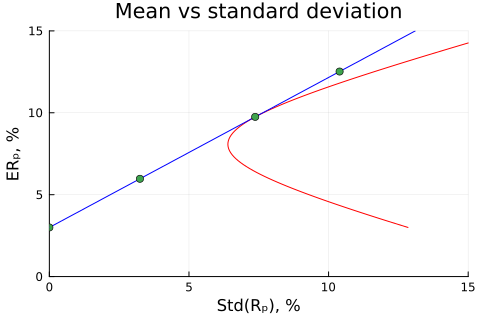

In [17]:
v_range = [0;0.44;1;1.41]                                 #try different mixes of wT and Rf

ERᵥ   = v_range*μT + (1 .- v_range)*Rf
StdRᵥ = abs.(v_range)*σT

p1 = plot( [StdRₚ StdRpRf]*100,μˣ_range*100,
           legend= nothing,
           linecolor = [:red :blue],
           xlim = (0,15),
           ylim = (0,15),
           title = "Mean vs standard deviation",
           xlabel = "Std(Rₚ), %",
           ylabel = "ERₚ, %" )
scatter!(StdRᵥ*100,ERᵥ*100)
display(p1)

## Examples of Tangency Portfolios

In [18]:
μb = [9; 6]/100                     #means
Σb = [ 256  0;
      0    144]/100^2
Rfb = 1/100
wT, = MVTangencyP(μb,Σb,Rfb)
printmat(wT;rowNames=["asset 1","asset 2"],prec)

wT, = MVTangencyP([13; 6]/100,Σb,Rfb)
printmat(wT;rowNames=["asset 1","asset 2"],prec)

Σb = [ 1  -0.8;
      -0.8    1]
wT, = MVTangencyP(μb,Σb,Rfb)
printmat(wT;rowNames=["asset 1","asset 2"],prec)

Σb = [ 1  0.8;
      0.8    1]
wT, = MVTangencyP(μb,Σb,Rfb)
printmat(wT;rowNames=["asset 1","asset 2"],prec)

asset 1      0.47
asset 2      0.53

asset 1      0.57
asset 2      0.43

asset 1      0.51
asset 2      0.49

asset 1      1.54
asset 2     -0.54



# Drawing the MV Frontier Revisited (extra)

Recall: with only two investable assets, all portfolios of them are on the MV frontier.

We apply this idea by using the global minimum variance portfolio (see below for code) and the tangency portfolios (see above).

In [19]:
"""
Calculate the global minimum variance portfolio
"""
function MVMinimumVarP(μ,Σ,Rf)
    n     = length(μ)
    μᵉ    = μ .- Rf
    Σ_1   = inv(Σ)
    w     = Σ_1*ones(n)/(ones(n)'Σ_1*ones(n))
    mu    = w'μ + (1-sum(w))*Rf
    Std   = sqrt(w'Σ*w)
    return w,mu,Std
end

MVMinimumVarP

In [20]:
(wT,μT,σT) = MVTangencyP(μ,Σ,Rf)
(wMvp,muMvp,StdMvp) = MVMinimumVarP(μ,Σ,Rf)
printblue("Tangency and minimum variance portfolios: ")
printmat([wT wMvp];colNames=["tangency","min var"],rowNames=assetNames,prec)

Tangency and minimum variance portfolios: 
   tangency   min var
A      0.25     -0.02
B      0.68      0.62
C      0.07      0.40



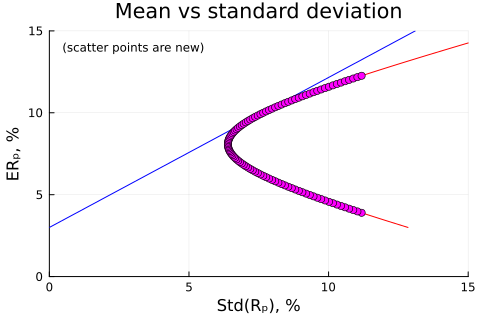

In [21]:
L = 101
v_range = range(-2.5,2.5,length=L)          #try different mixes of wT and wMvp

(ERᵥ,StdRᵥ)  = (fill(NaN,L),fill(NaN,L))
for i = 1:L
    #local w                                #local/global is needed in script
    w        = v_range[i]*wT + (1-v_range[i])*wMvp
    ERᵥ[i]   = w'μ
    StdRᵥ[i] = sqrt(w'Σ*w)
end

p1 = plot( [StdRₚ StdRpRf]*100,μˣ_range*100,
           legend = nothing,
           linecolor = [:red :blue],
           xlim = (0,15),
           ylim = (0,15),
           title = "Mean vs standard deviation",
           xlabel = "Std(Rₚ), %",
           ylabel = "ERₚ, %",
           annotation = (0.5,14,text("(scatter points are new)",8,:left)) )
scatter!(StdRᵥ*100,ERᵥ*100,markercolor=:magenta)
display(p1)